Dans ce script, nous allons tester différents modèles de type convolution Nelle pour examiner leur performance. Nous allons ensuite tester s'ils sont robustes lorsqu'on applique une rotation à l'image d'entrée.

# displaying sample images

In [1]:
import retinoto_py as fovea
N_show = 6
args = fovea.Params(batch_size=N_show, do_mask=False)
args

Welcome on macOS-26.1-arm64-arm-64bit-Mach-O	 user laurentperrinet	Running on MPS device (Apple Silicon/MacOS)	 - macos_version = 26.1	 with device mps, pytorch==2.9.1
Random seed 1998 has been set.


Params(image_size=224, do_mask=False, num_epochs=10, n_train_stop=0, seed=1998, batch_size=6, num_workers=4, model_name='resnet50', do_scratch=False, lr=0.02, delta1=0.1, delta2=0.001, weight_decay=0.001, shuffle=True, verbose=True)

In [2]:
VAL_DATA_DIR = args.DATAROOT / 'Imagenet_full' / 'val'
# VAL_DATA_DIR = args.DATAROOT / 'Imagenet_bbox' / 'val'
val_loader, class_to_idx, idx_to_class = fovea.get_loader(args, VAL_DATA_DIR)

In [3]:
for images, labels in val_loader:
    images, labels = images.to('cpu'), labels.to('cpu')
    break

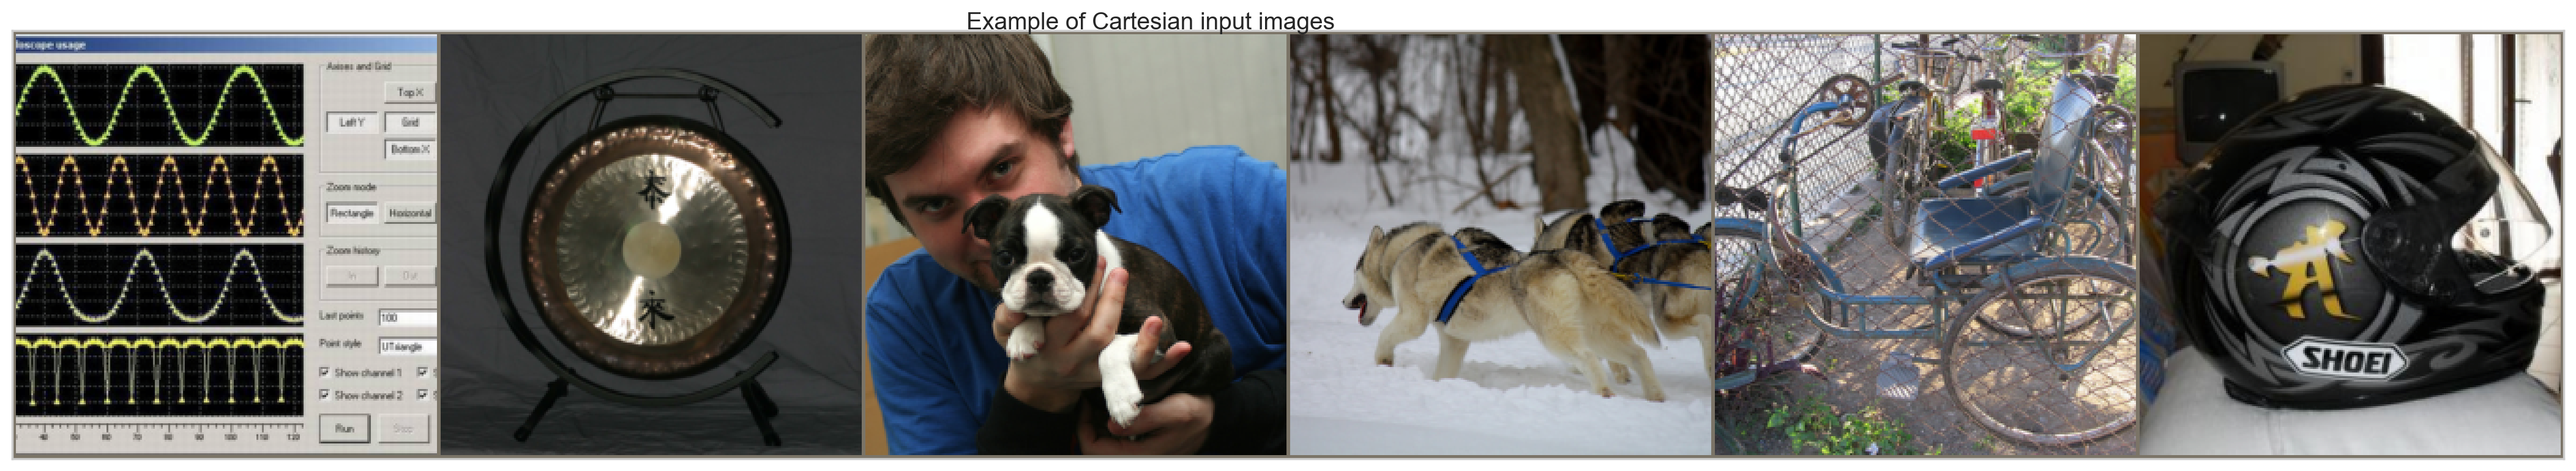

In [4]:
fig, ax = fovea.imshow(images, title='Example of Cartesian input images', fig_height=5)
fovea.plt.show()


# displaying sample images with a mask

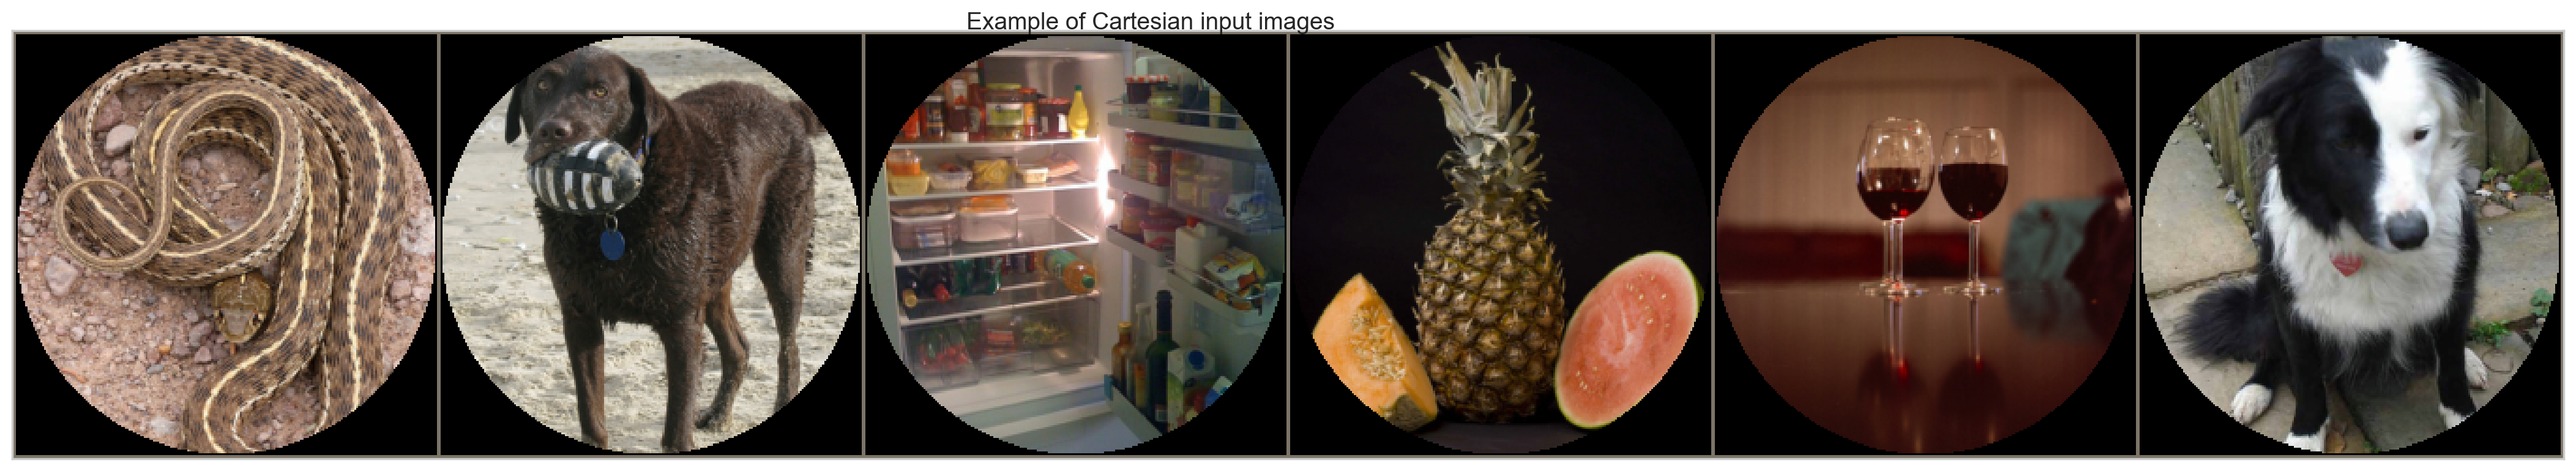

In [5]:
args = fovea.Params(batch_size=N_show, do_mask=True)
val_loader, class_to_idx, idx_to_class = fovea.get_loader(args, VAL_DATA_DIR)
for images, labels in val_loader:
    images, labels = images.to('cpu'), labels.to('cpu')
    break
fig, ax = fovea.imshow(images, title='Example of Cartesian input images', fig_height=5)
fovea.plt.show()


# displaying sample images with a mask and a rotation

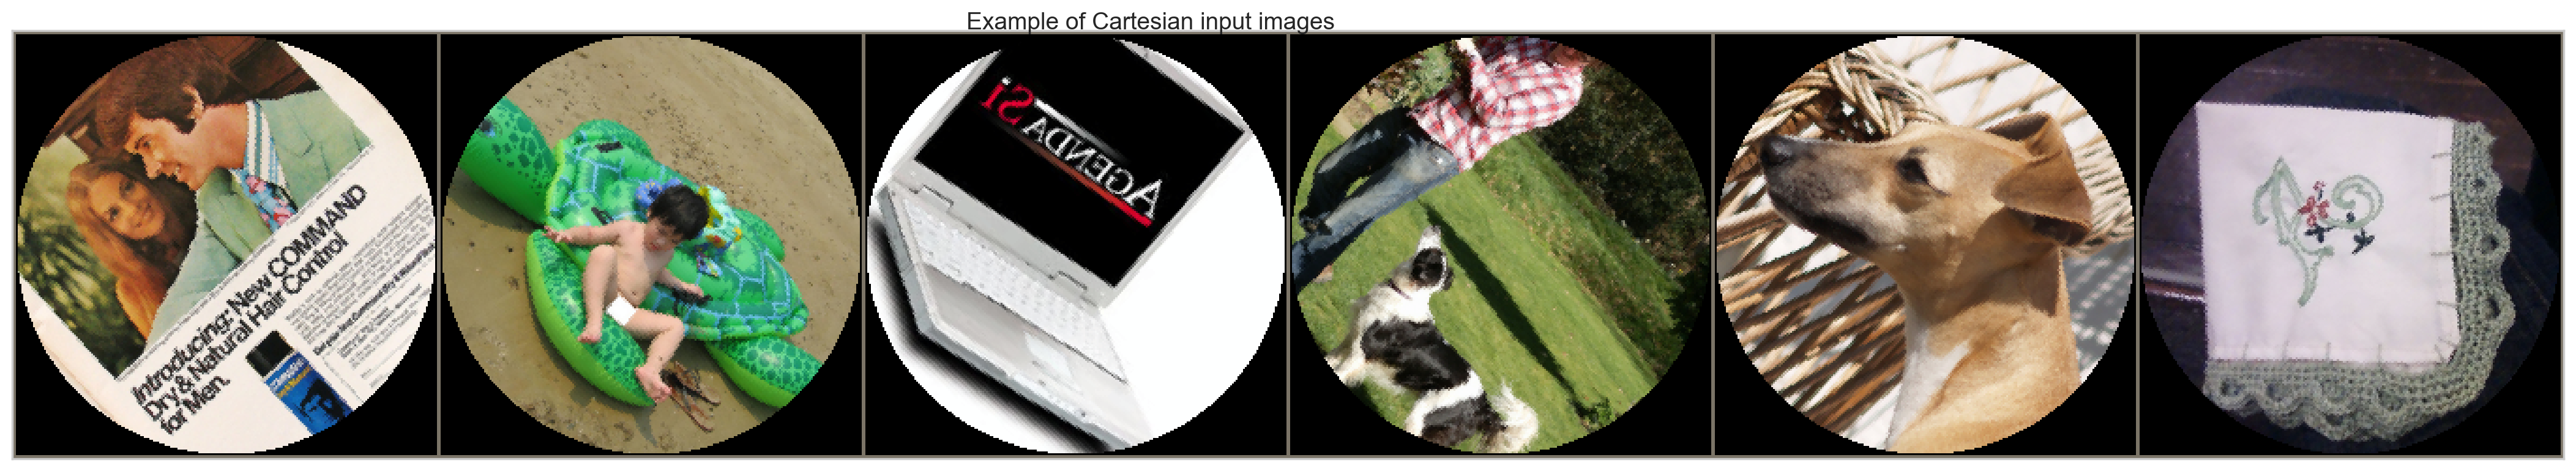

In [6]:
args = fovea.Params(batch_size=N_show, do_mask=True)
val_loader, class_to_idx, idx_to_class = fovea.get_loader(args, VAL_DATA_DIR, angle_min=40, angle_max=50)
for images, labels in val_loader:
    images, labels = images.to('cpu'), labels.to('cpu')
    break
fig, ax = fovea.imshow(images, title='Example of Cartesian input images', fig_height=5)
fovea.plt.show()


# testing one image at different rotations

In [ ]:
args = fovea.Params(batch_size=1, do_mask=True, shuffle=True, seed=1973)
val_loader, class_to_idx, idx_to_class = fovea.get_loader(args, VAL_DATA_DIR)
model = fovea.load_model(args)
model.eval()
for images, true_labels in val_loader:
    images = images.to(args.device)
    true_labels = true_labels.to(args.device)
    break
images.shape, true_labels


(torch.Size([1, 3, 224, 224]), tensor([101], device='mps:0'))

In [8]:
all_angles = fovea.np.linspace(0, 360, 22) 


In [9]:
all_image_tensors = []
all_label_tensors = []

mask = fovea.make_mask(args.image_size).to(args.device)
for angle in all_angles:
    image_rot = fovea.TF.rotate(images, angle) * mask
    
    # Append the batch of rotated images and their corresponding labels
    all_image_tensors.append(image_rot)
    all_label_tensors.append(true_labels) # Append the full label tensor

# --- AFTER THE LOOP: Concatenate everything at once ---
# This is the efficient way!
all_images = fovea.torch.cat(all_image_tensors, dim=0)
all_labels = fovea.torch.cat(all_label_tensors, dim=0)

all_images.shape, all_labels.shape

(torch.Size([22, 3, 224, 224]), torch.Size([22]))

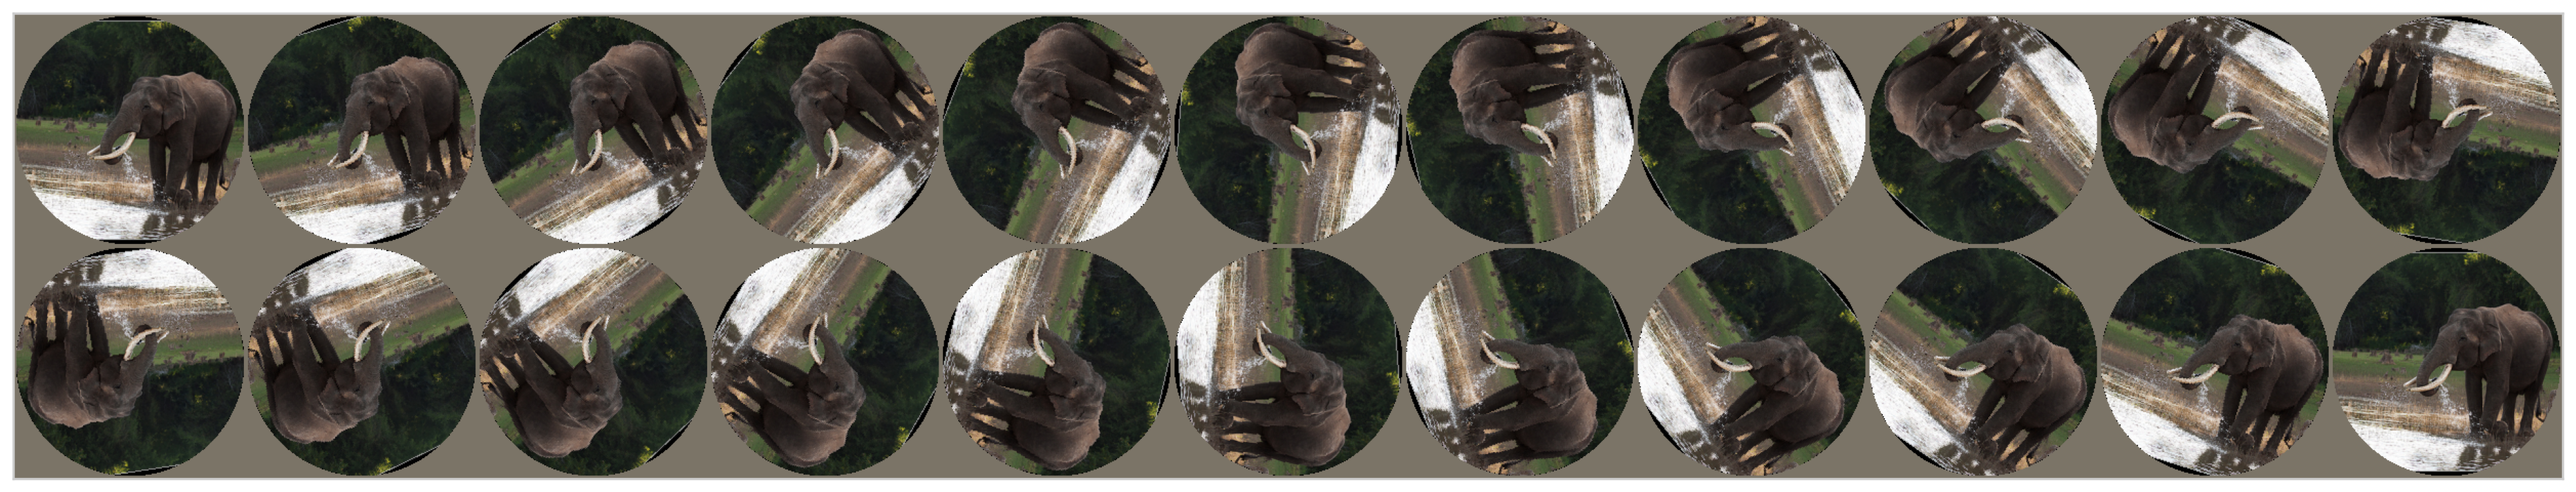

In [10]:
fig, ax = fovea.imshow(all_images.cpu(), fig_height=5)

In [11]:
criterion = fovea.nn.CrossEntropyLoss(reduction='none')
with fovea.torch.no_grad():
    outputs = model(all_images)
    loss = criterion(outputs, all_labels).cpu().numpy()
    logits = outputs.cpu().numpy()

    _, predicted_labels = fovea.torch.max(outputs, dim=1)
    correct_predictions_in_batch = (predicted_labels == all_labels)
predicted_labels, all_labels

(tensor([101, 101, 101, 101, 101, 101, 385, 386, 101, 385, 386, 385, 385, 385, 385, 101, 101, 101, 101, 101, 101, 101], device='mps:0'),
 tensor([101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101, 101], device='mps:0'))

In [12]:
correct_predictions_in_batch, loss

(tensor([ True,  True,  True,  True,  True,  True, False, False,  True, False, False, False, False, False, False,  True,  True,  True,  True,
          True,  True,  True], device='mps:0'),
 array([1.1712483, 0.9624603, 1.3396039, 1.3947866, 1.2262695, 1.3027698,
        1.7171407, 2.0866184, 1.7158325, 2.1397405, 2.2933424, 2.334763 ,
        2.8059542, 1.7156929, 1.8952376, 1.4640632, 1.1776338, 1.2349646,
        1.3160845, 1.4732229, 1.1875463, 1.1712483], dtype=float32))

In [13]:
worst_angle = loss.argmax()
worst_angle, predicted_labels[worst_angle]

(np.int64(12), tensor(385, device='mps:0'))

In [14]:
idx_to_label = fovea.get_idx_to_label(args)
idx_to_label[predicted_labels[worst_angle]]

Loading labels from local cache cached_data/imagenet_class_index.json...


'Indian_elephant'

In [15]:
all_images[[0, worst_angle], ...].shape

torch.Size([2, 3, 224, 224])

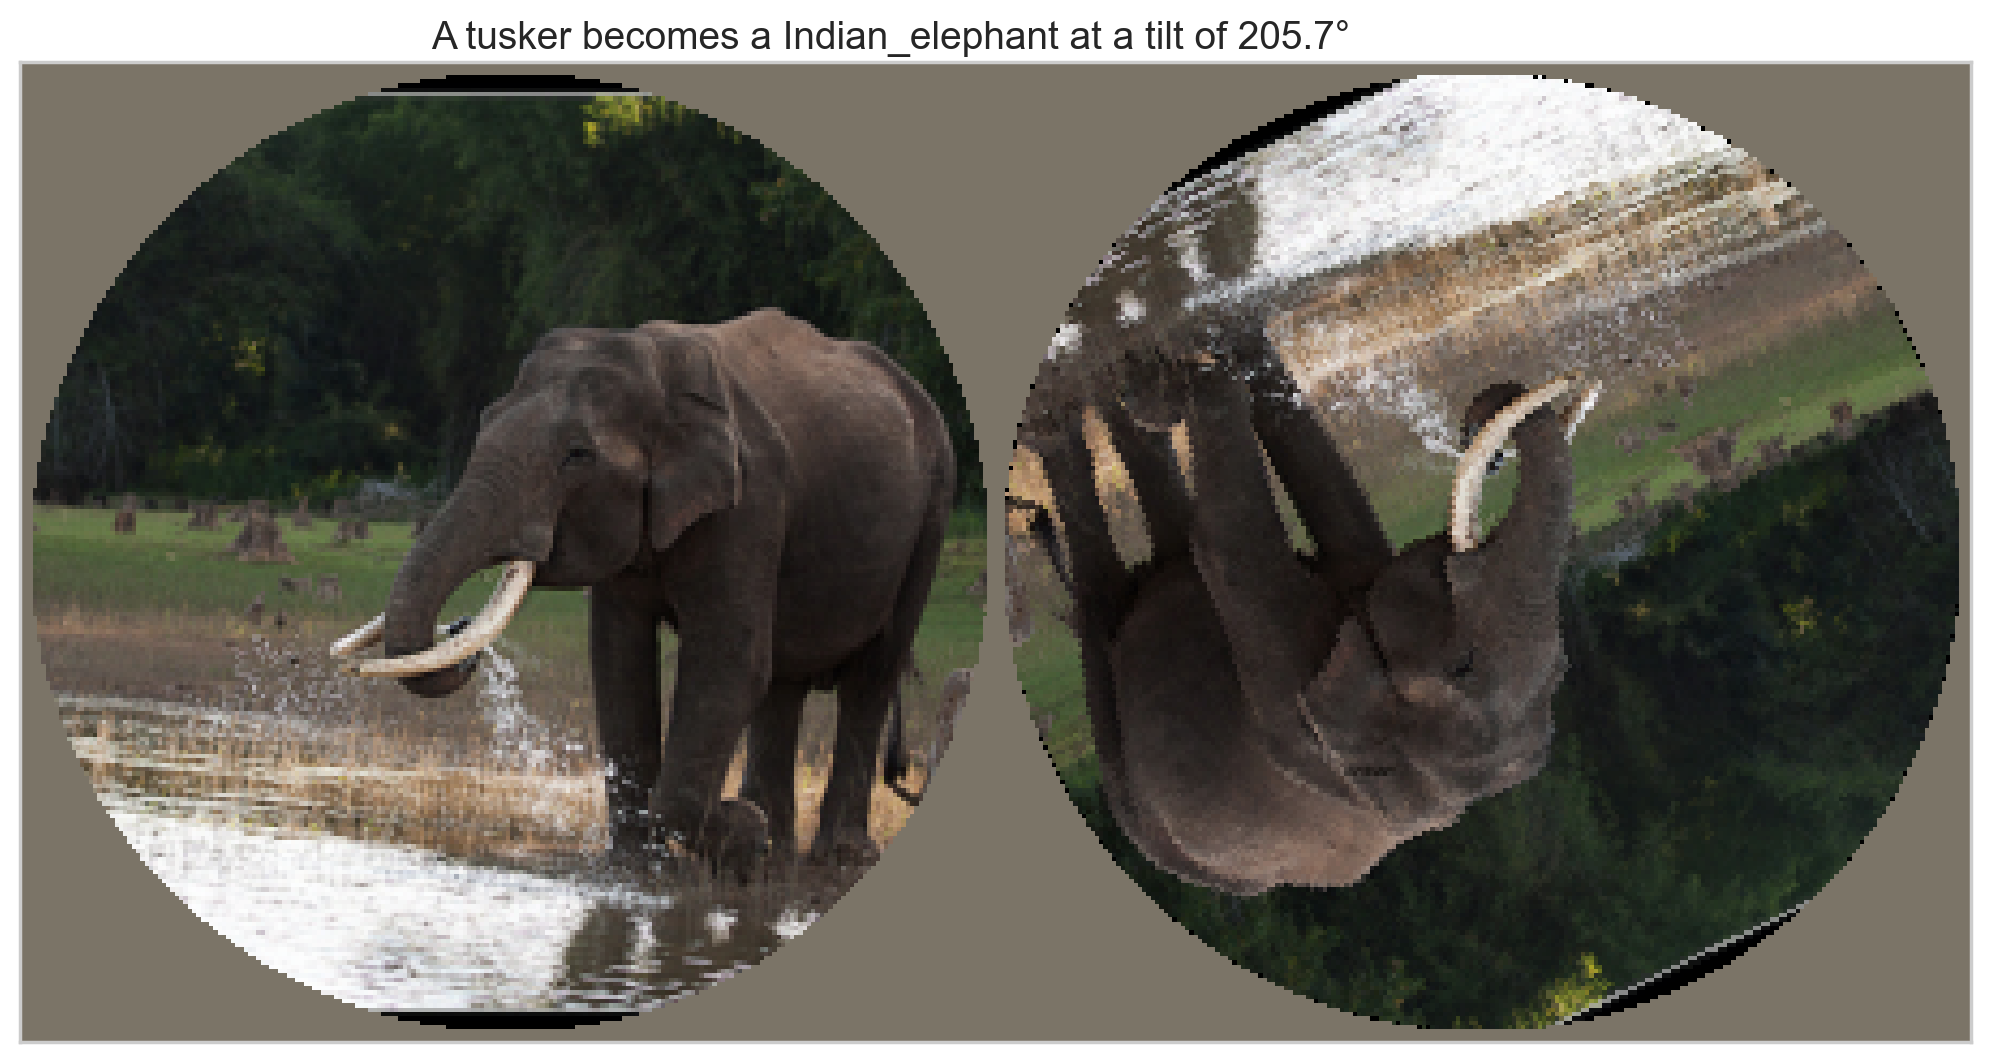

In [16]:
fig, ax = fovea.imshow(all_images[[0, worst_angle], ...].cpu(), title=f'A {idx_to_label[predicted_labels[0]]} becomes a {idx_to_label[predicted_labels[worst_angle]]} at a tilt of {all_angles[worst_angle]:.1f}°', fig_height=7)

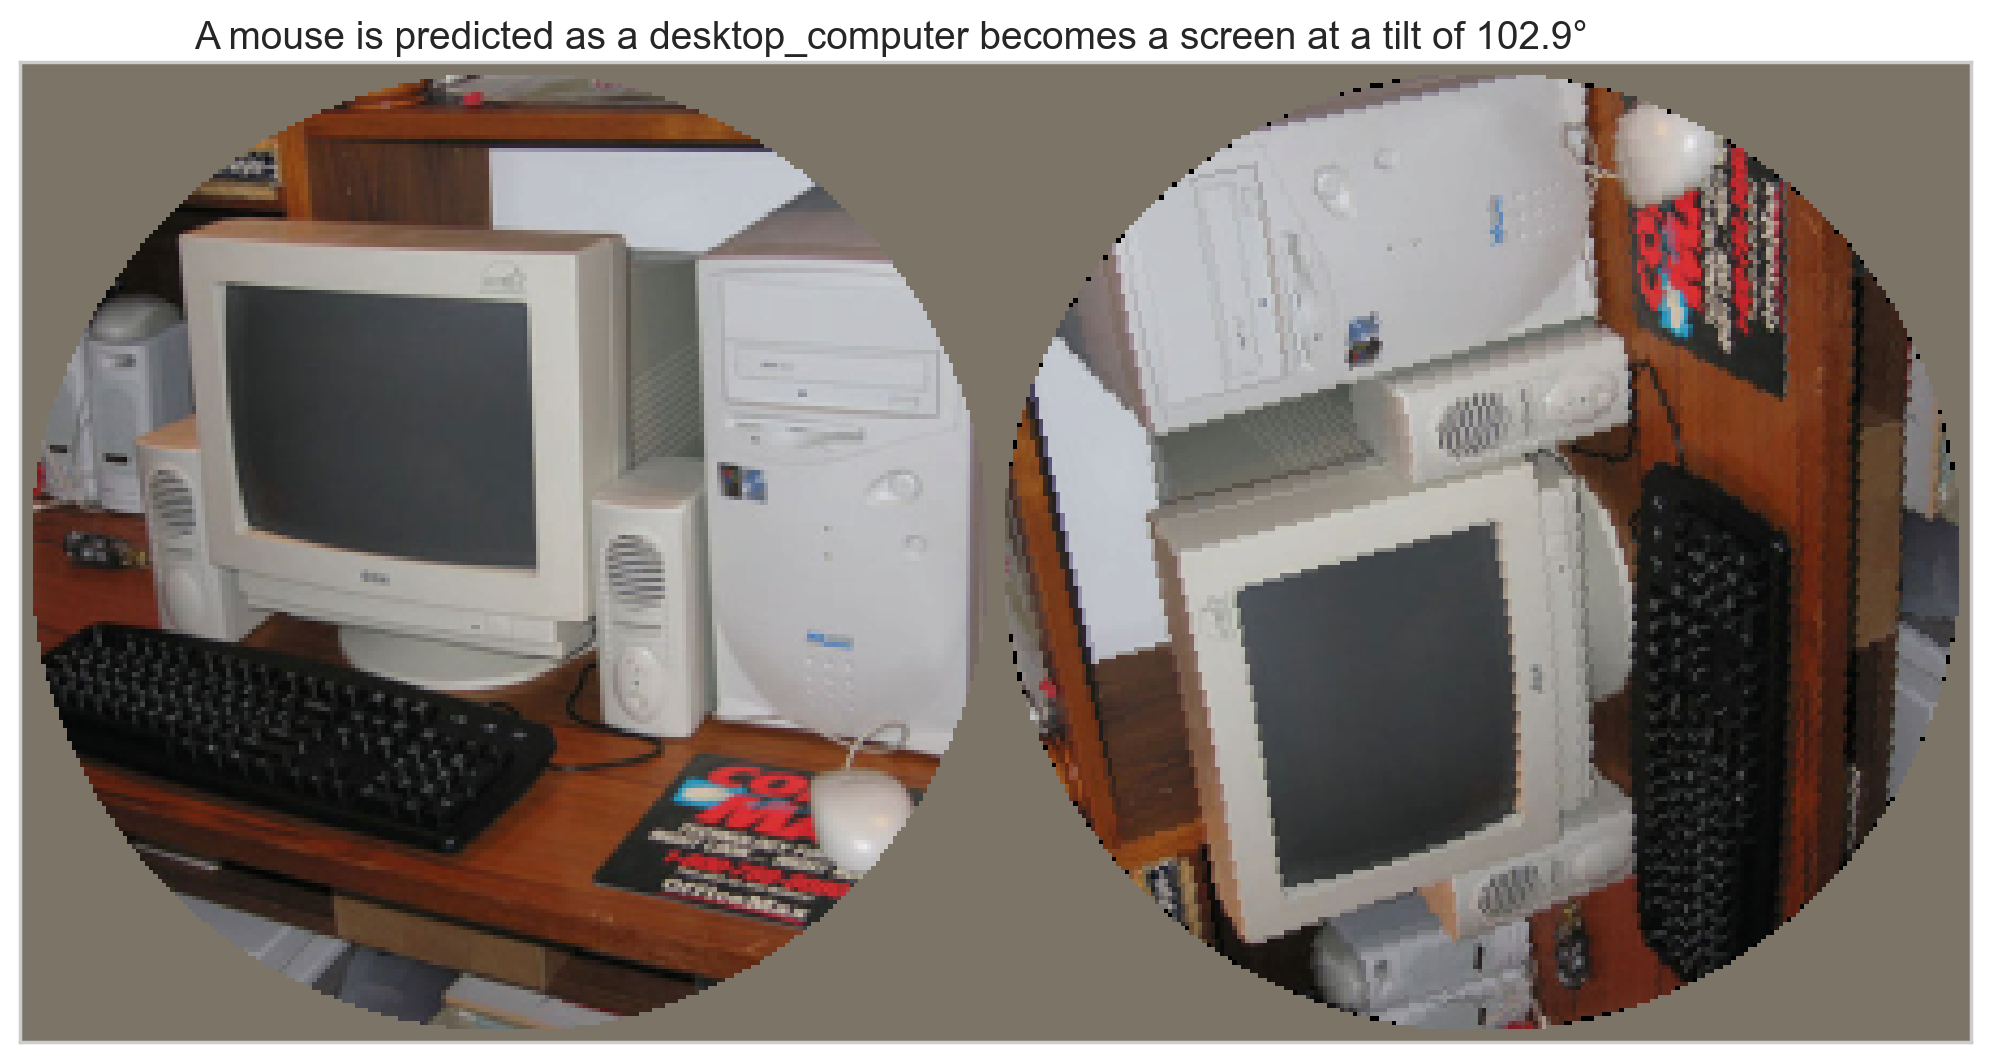

In [ ]:
def one_rotation_attack(all_angles=fovea.np.linspace(0, 360, 22), seed=42):
    args = fovea.Params(batch_size=1, do_mask=True, shuffle=True, seed=seed)
    val_loader, class_to_idx, idx_to_class = fovea.get_loader(args, VAL_DATA_DIR)
    model = fovea.load_model(args)
    model.eval()
    for images, true_labels in val_loader:
        images = images.to(args.device)
        true_labels = true_labels.to(args.device)
        break

    all_image_tensors = []
    all_label_tensors = []
    for angle in all_angles:
        image_rot = fovea.TF.rotate(images, angle) * mask
        all_image_tensors.append(image_rot)
        all_label_tensors.append(true_labels) # Append the full label tensor
    all_images = fovea.torch.cat(all_image_tensors, dim=0)
    all_labels = fovea.torch.cat(all_label_tensors, dim=0)

    with fovea.torch.no_grad():
        outputs = model(all_images)
        loss = criterion(outputs, all_labels).cpu().numpy()
        _, predicted_labels = fovea.torch.max(outputs, dim=1)

    worst_angle = loss.argmax()
    
    fig, ax = fovea.imshow(all_images[[0, worst_angle], ...].cpu(), title=f'A {idx_to_label[all_labels[0]]} is predicted as a {idx_to_label[predicted_labels[0]]} becomes a {idx_to_label[predicted_labels[worst_angle]]} at a tilt of {all_angles[worst_angle]:.1f}°', fig_height=7)
    fig.subplots_adjust(top=0.85)
    return fig, ax

fig, ax = one_rotation_attack(seed=2030)


In [18]:

figures_folder = args.figures_folder / '16_attack'
figures_folder.mkdir(exist_ok=True)
for seed in range(42, 52):
    fig, ax = one_rotation_attack(seed=seed)
    name =  f'16_attack-{seed=}_{args.model_name}'
    fovea.savefig(fig, name=name, figures_folder=args.figures_folder / '16_attack')
    fovea.plt.close() # will close the plot
    print(f'Saved {name}')

Saved 16_attack-seed=42_resnet50
Saved 16_attack-seed=43_resnet50
Saved 16_attack-seed=44_resnet50
Saved 16_attack-seed=45_resnet50
Saved 16_attack-seed=46_resnet50
Saved 16_attack-seed=47_resnet50
Saved 16_attack-seed=48_resnet50
Saved 16_attack-seed=49_resnet50
Saved 16_attack-seed=50_resnet50
Saved 16_attack-seed=51_resnet50


# testing each network for different rotations

In [19]:
all_angles = fovea.np.linspace(-180, 180, 121)
all_angles = fovea.np.linspace(0, 180, 24)
all_angles = fovea.np.linspace(0, 180, 4) 
all_angles = fovea.np.linspace(0, 180, 13)
all_angles

array([  0.,  15.,  30.,  45.,  60.,  75.,  90., 105., 120., 135., 150.,
       165., 180.])

In [20]:
delta_angle = all_angles[1] - all_angles[0]
all_angles_min = all_angles - delta_angle / 2
all_angles_min, all_angles_min + delta_angle, delta_angle

(array([ -7.5,   7.5,  22.5,  37.5,  52.5,  67.5,  82.5,  97.5, 112.5,
        127.5, 142.5, 157.5, 172.5]),
 array([  7.5,  22.5,  37.5,  52.5,  67.5,  82.5,  97.5, 112.5, 127.5,
        142.5, 157.5, 172.5, 187.5]),
 np.float64(15.0))

In [21]:
for model_name in  fovea.all_model_names:
    print(f'{model_name=}')



model_name='resnet18'
model_name='resnet50'
model_name='resnet101'


In [22]:
for angles_min, angles_max in zip(all_angles_min, all_angles_min + delta_angle):
    print(f'{fovea.np.mod(angles_min,360)=:.3f}\t{fovea.np.mod(angles_max, 360)=:.3f}')

fovea.np.mod(angles_min,360)=352.500	fovea.np.mod(angles_max, 360)=7.500
fovea.np.mod(angles_min,360)=7.500	fovea.np.mod(angles_max, 360)=22.500
fovea.np.mod(angles_min,360)=22.500	fovea.np.mod(angles_max, 360)=37.500
fovea.np.mod(angles_min,360)=37.500	fovea.np.mod(angles_max, 360)=52.500
fovea.np.mod(angles_min,360)=52.500	fovea.np.mod(angles_max, 360)=67.500
fovea.np.mod(angles_min,360)=67.500	fovea.np.mod(angles_max, 360)=82.500
fovea.np.mod(angles_min,360)=82.500	fovea.np.mod(angles_max, 360)=97.500
fovea.np.mod(angles_min,360)=97.500	fovea.np.mod(angles_max, 360)=112.500
fovea.np.mod(angles_min,360)=112.500	fovea.np.mod(angles_max, 360)=127.500
fovea.np.mod(angles_min,360)=127.500	fovea.np.mod(angles_max, 360)=142.500
fovea.np.mod(angles_min,360)=142.500	fovea.np.mod(angles_max, 360)=157.500
fovea.np.mod(angles_min,360)=157.500	fovea.np.mod(angles_max, 360)=172.500
fovea.np.mod(angles_min,360)=172.500	fovea.np.mod(angles_max, 360)=187.500


In [23]:
npz_filename = args.data_cache / f'16_all_{args.model_name}.npz'

# %rm {npz_filename}  # FORCING RECOMPUTE

if npz_filename.exists():
    with fovea.np.load(npz_filename) as data:
        # --- 3. Access the arrays inside the 'with' block ---
        # It's good practice to convert to tensors (or whatever final format you need)
        # right away, so you don't need to keep the file open.
        attack_angle = data['attack_angle']
        attack_success = data['attack_success']
        all_results = data['results']
else:
    VAL_DATA_DIR = args.DATAROOT / 'Imagenet_full' / 'val'
    model = fovea.load_model(args)
    model.eval()

    # https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html 
    criterion = fovea.nn.CrossEntropyLoss(reduction='none')
    dataset_len = len(val_loader.dataset)
    all_results = fovea.np.empty((len(all_angles), dataset_len)) 
    all_logits = fovea.np.empty((len(all_angles), dataset_len, model.fc.out_features)) 
    all_losses = fovea.np.empty((len(all_angles), dataset_len)) 
    all_labels = []
    for i_angle, (angle_min, angle_max) in enumerate(zip(all_angles_min, all_angles_min + delta_angle)):
        args = fovea.Params(shuffle=False, do_mask=True)
        val_loader, class_to_idx, idx_to_class = fovea.get_loader(args, VAL_DATA_DIR, angle_min=angle_min, angle_max=angle_max)

        correct_predictions = 0
        total_predictions = 0

        image_count = 0
        for images, true_labels in val_loader:
            print(f'Processing angle {i_angle+1}/{len(all_angles)} \t images {image_count}/{len(val_loader.dataset)}', end='\r')
            images = images.to(args.device)
            true_labels = true_labels.to(args.device)

            # Get predictions (no need for gradients)
            with fovea.torch.no_grad():
                if i_angle==0: all_labels.extend([l.item() for l in true_labels])
                outputs = model(images)
                all_logits[i_angle, image_count:(image_count + images.size(0)), :] = outputs.cpu().numpy()
                _, predicted_labels = fovea.torch.max(outputs, dim=1)
                correct_predictions_in_batch = (predicted_labels == true_labels)
                all_results[i_angle, image_count:image_count + images.size(0)] = correct_predictions_in_batch.cpu().numpy()
                loss = criterion(outputs, true_labels)
                all_losses[i_angle, image_count:(image_count + images.size(0))] = loss.cpu().numpy()
            image_count += images.size(0)

    attack_angle = all_losses.argmax(axis=0)
    attack_idx = all_logits[attack_angle, fovea.np.arange(dataset_len), :].argmax(axis=1)
    attack_success = (attack_idx == all_labels)


    fovea.np.savez(npz_filename, 
            attack_angle=attack_angle,
            attack_success=attack_success,
            results=all_results)



# analysis: average accuracy for different rotations

In [24]:
all_results.shape

(13, 50000)

In [25]:
all_results.mean(axis=1)

array([0.76694, 0.64606, 0.65214, 0.68214, 0.59694, 0.55608, 0.69454,
       0.53392, 0.54234, 0.59486, 0.50184, 0.46868, 0.63406])

(0.0, 1.05)

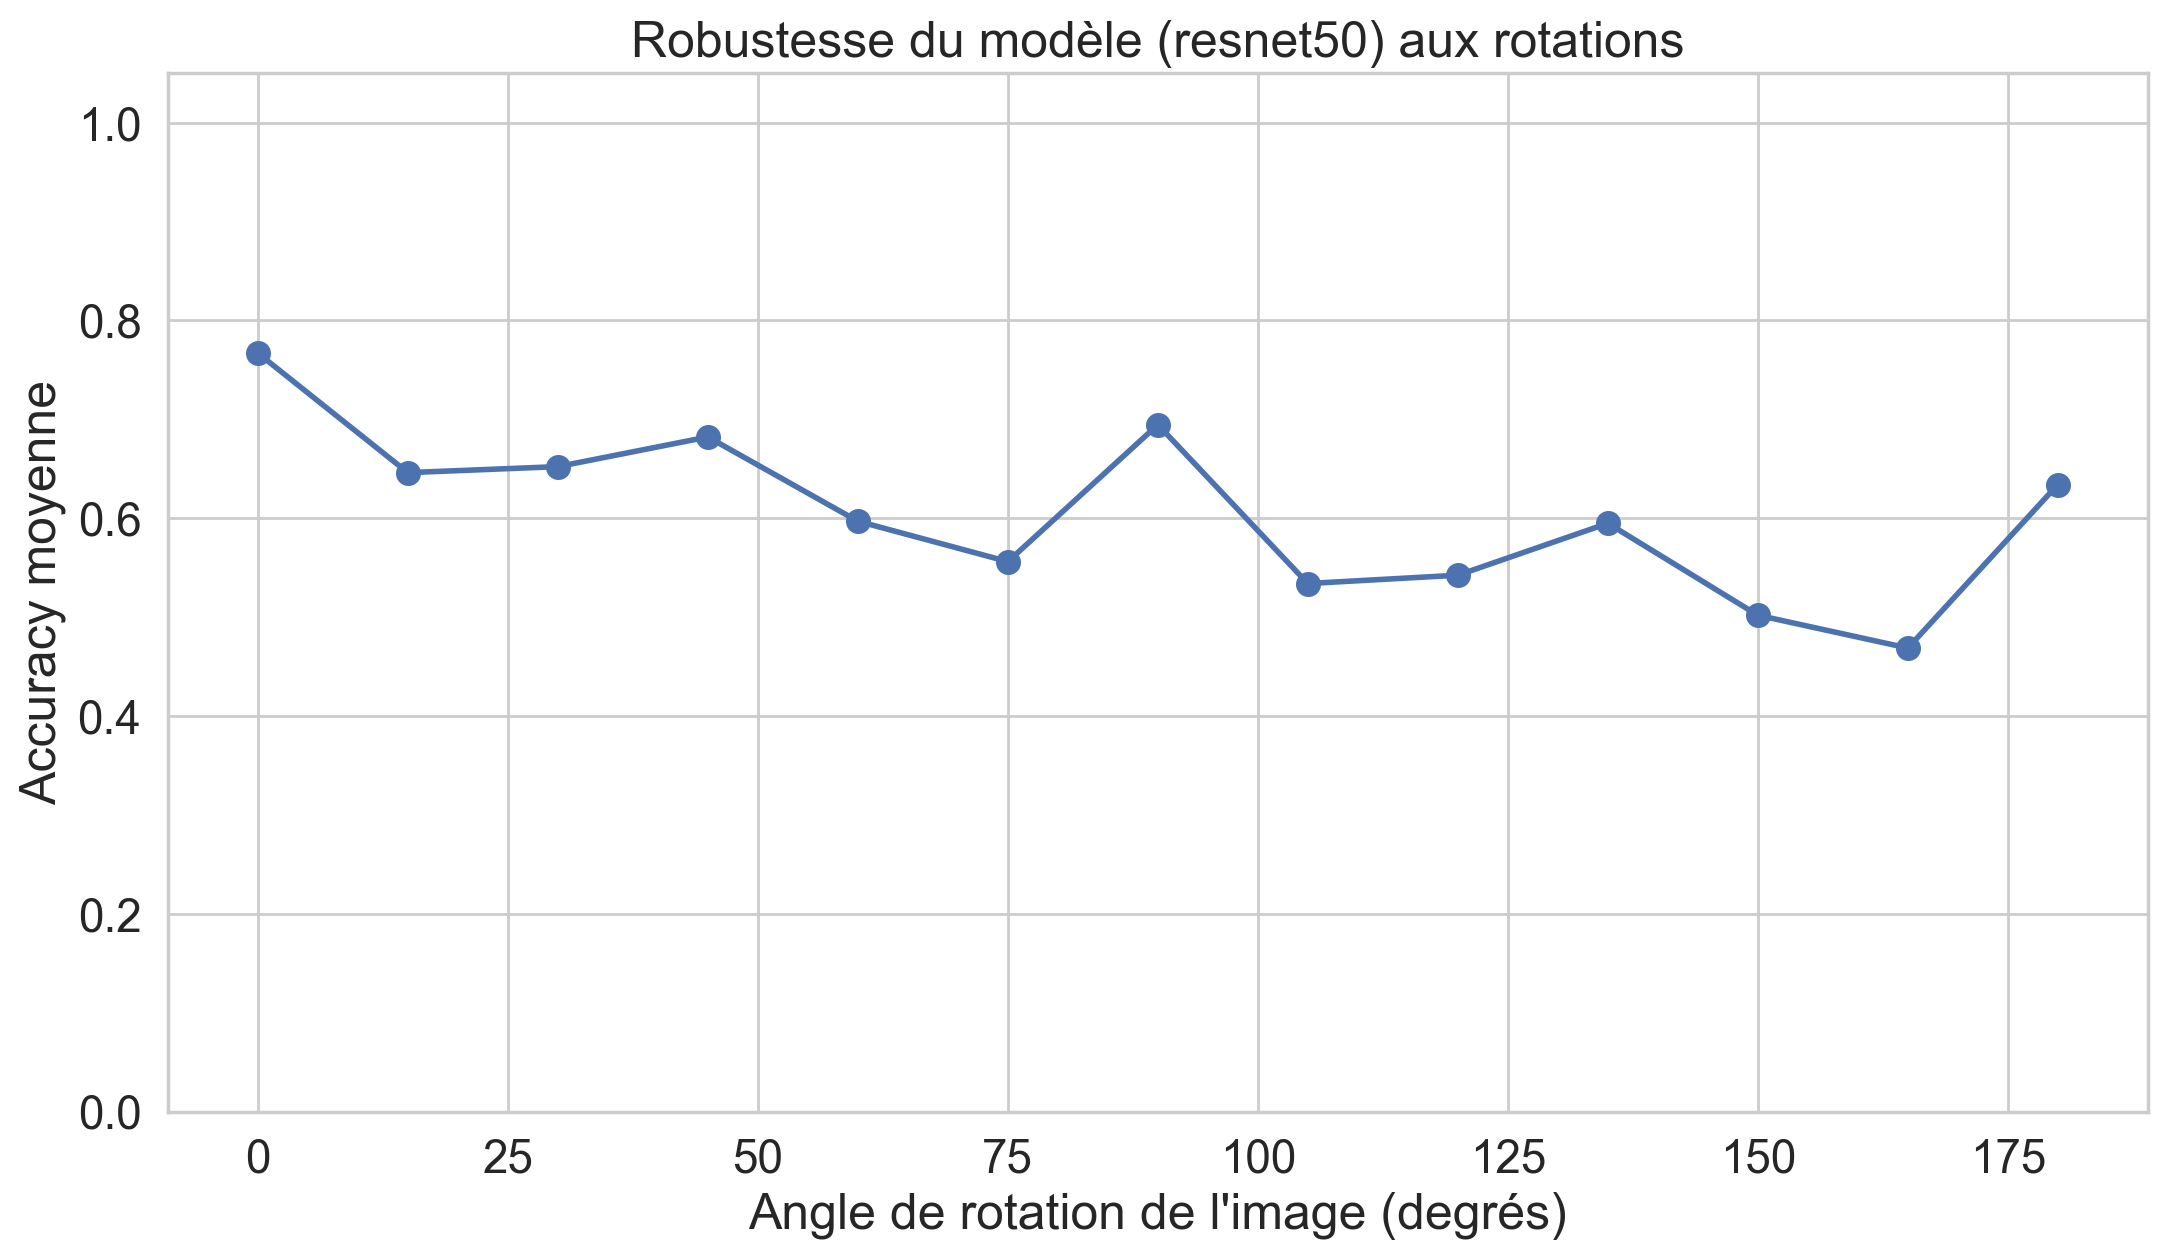

In [26]:
# `all_results` est un tableau de booléens (True/False pour correct/incorrect)
# Pour calculer la précision, on calcule la moyenne (True=1, False=0) sur l'axe des images (axe=1)
mean_accuracy_per_angle = all_results.mean(axis=1)

# --- Création du Plot ---
fig, ax = fovea.plt.subplots()

# Tracer l'accuracy moyenne en fonction de l'angle de référence
ax.plot(all_angles, mean_accuracy_per_angle, marker='o', linestyle='-', lw=2, markersize=8)

# --- Finalisation du Graphique ---
ax.set_xlabel("Angle de rotation de l'image (degrés)")
ax.set_ylabel("Accuracy moyenne")
ax.set_title(f"Robustesse du modèle ({args.model_name}) aux rotations")
ax.set_ylim(0, 1.05) # S'assurer que l'axe des y est bien entre 0 et 1

# On peut ajouter une ligne horizontale pour la performance de base (angle=0)
# if 0 in all_angles[:-1]:
#     base_accuracy = mean_accuracy_per_angle[all_angles == 0][0]
#     plt.axhline(y=base_accuracy, color='r', linestyle='--', label=f'Performance de base (angle=0): {base_accuracy:.2f}')
#     plt.legend()


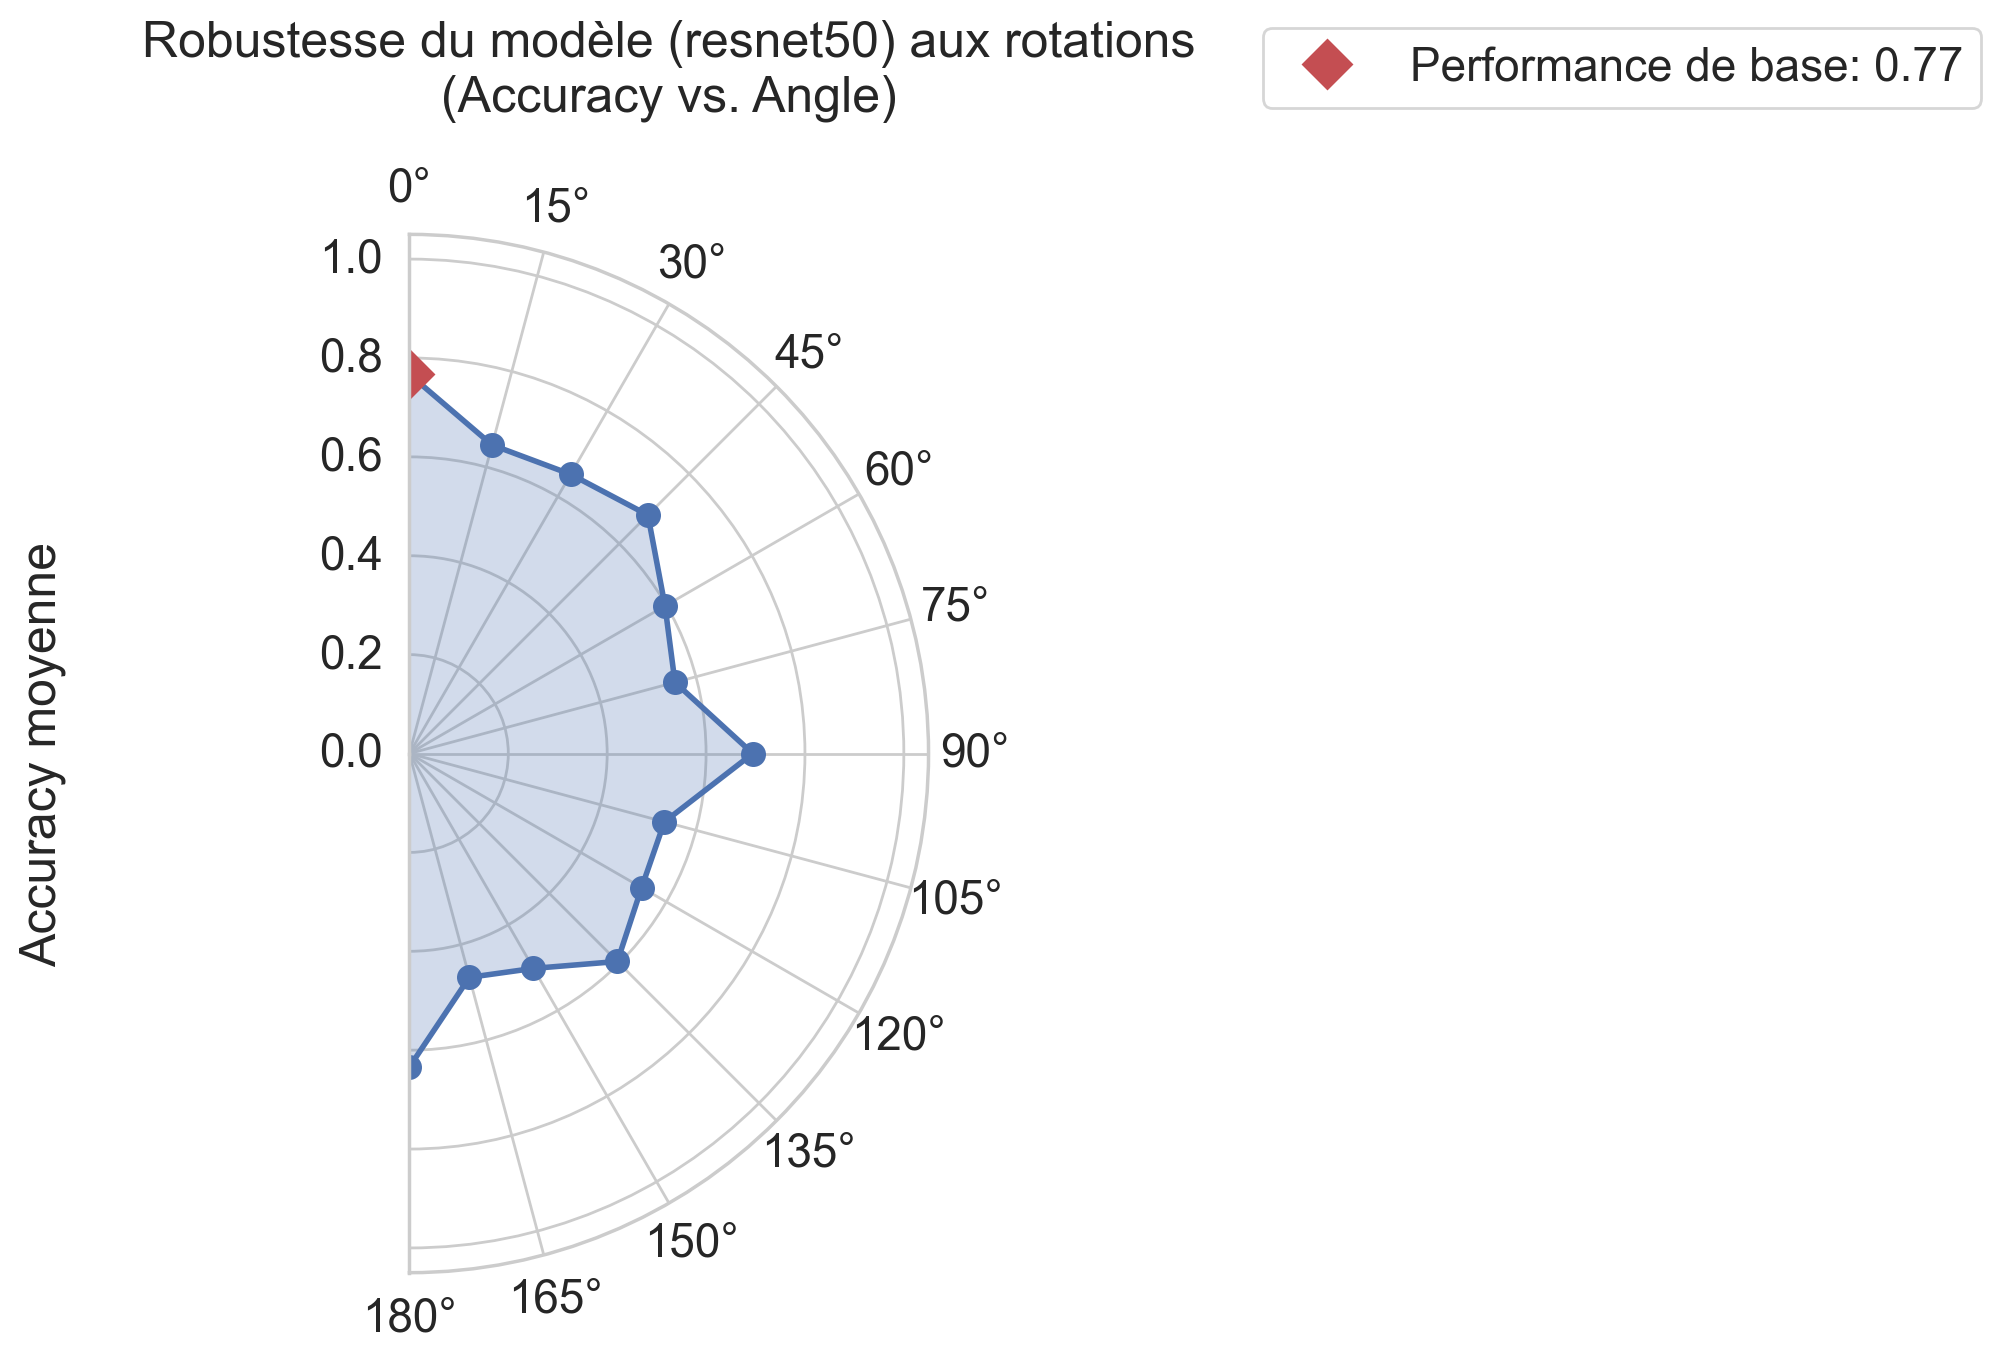

In [27]:
# --- Création du Polar Plot ---

# 1. Créer la figure et l'axe en projection polaire
fig = fovea.plt.figure()
ax = fig.add_subplot(111, polar=True)

# 2. Convertir les angles de degrés en radians (nécessaire pour Matplotlib)
angles_rad = fovea.np.deg2rad(all_angles)

# 3. Tracer les données en coordonnées polaires
ax.plot(angles_rad, mean_accuracy_per_angle, marker='o', linestyle='-', lw=2, markersize=8, color='b')

# 4. Remplir la zone sous la courbe pour un meilleur effet visuel
ax.fill(angles_rad, mean_accuracy_per_angle, alpha=0.25, color='b')

# --- Finalisation du Graphique Polaire ---
# Définir la direction du zéro (haut) et le sens horaire/anti-horaire
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1) # -1 pour horaire, 1 pour anti-horaire

# Définir les étiquettes des angles sur le cercle
# S'assurer que les étiquettes sont alignées
ax.set_thetagrids(fovea.np.degrees(angles_rad), labels=[f'{a:.0f}°' for a in all_angles])

# Définir les limites et les étiquettes de l'axe radial (l'accuracy)
ax.set_xlim(0, fovea.np.pi)
ax.set_ylim(0, 1.05)
ax.set_ylabel("Accuracy moyenne", labelpad=30) # labelpad pour éloigner l'étiquette du graphique
ax.set_rlabel_position(45) # Positionner l'étiquette de l'axe radial

# Ajouter un titre
ax.set_title(f"Robustesse du modèle ({args.model_name}) aux rotations\n(Accuracy vs. Angle)", pad=20)

# Ajouter la ligne de performance de base (angle=0)
# Il faut trouver l'index de l'angle le plus proche de 0
zero_angle_idx = (fovea.np.abs(all_angles)).argmin()
base_accuracy = mean_accuracy_per_angle[zero_angle_idx]
ax.plot(angles_rad[zero_angle_idx], base_accuracy, 'rD', markersize=12, label=f'Performance de base: {base_accuracy:.2f}')
ax.legend(loc='lower left', bbox_to_anchor=(1.05, 1.1))

In [28]:
all_angles

array([  0.,  15.,  30.,  45.,  60.,  75.,  90., 105., 120., 135., 150.,
       165., 180.])

In [29]:
all_angles_wrap = fovea.np.hstack((all_angles, fovea.np.mod(all_angles[1:]+180, 360)))
all_angles_wrap

array([  0.,  15.,  30.,  45.,  60.,  75.,  90., 105., 120., 135., 150.,
       165., 180., 195., 210., 225., 240., 255., 270., 285., 300., 315.,
       330., 345.,   0.])

In [30]:
mean_accuracy_per_angle_wrap = fovea.np.hstack((mean_accuracy_per_angle, mean_accuracy_per_angle[:-1][::-1]))
mean_accuracy_per_angle_wrap

array([0.76694, 0.64606, 0.65214, 0.68214, 0.59694, 0.55608, 0.69454,
       0.53392, 0.54234, 0.59486, 0.50184, 0.46868, 0.63406, 0.46868,
       0.50184, 0.59486, 0.54234, 0.53392, 0.69454, 0.55608, 0.59694,
       0.68214, 0.65214, 0.64606, 0.76694])

/var/folders/3s/q2x8bxzj43g4rdvb2wjt67640000gq/T/ipykernel_28804/217229453.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(loc='lower left', bbox_to_anchor=(1.05, 1.1))


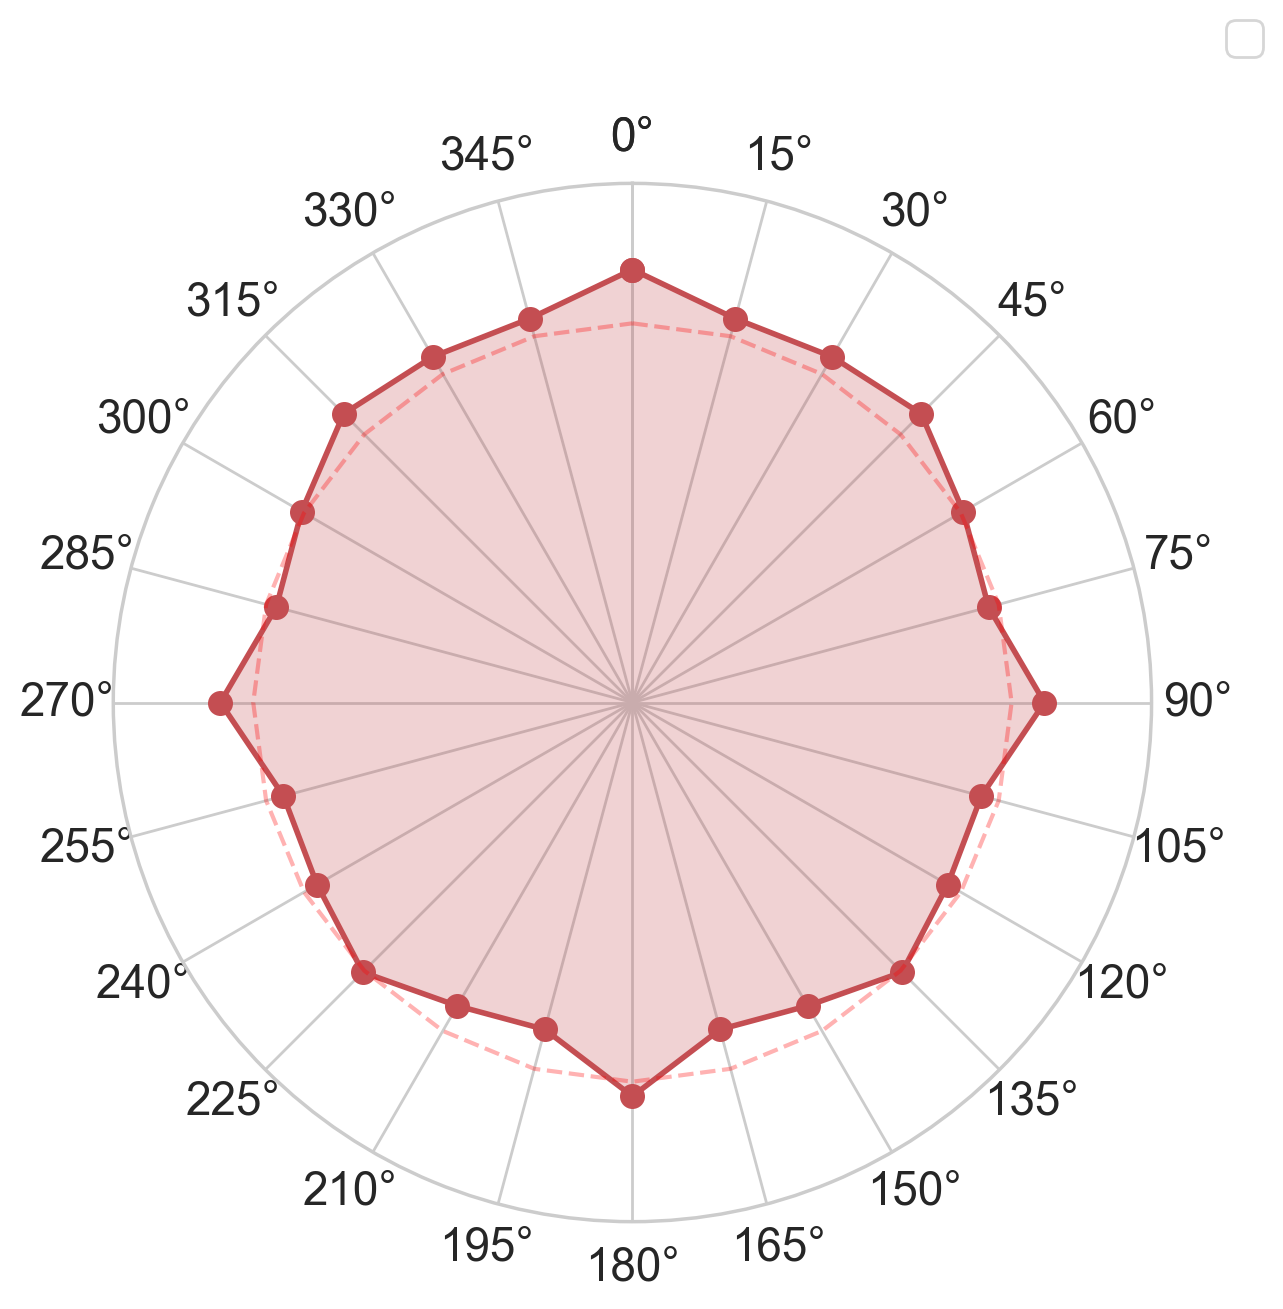

In [43]:
# --- Création du Polar Plot ---

# 1. Créer la figure et l'axe en projection polaire
fig = fovea.plt.figure()
ax = fig.add_subplot(111, polar=True)

# 2. Convertir les angles de degrés en radians (nécessaire pour Matplotlib)
angles_rad = fovea.np.deg2rad(all_angles_wrap)

# 3. Tracer les données en coordonnées polaires
ax.plot(angles_rad, fovea.np.sqrt(mean_accuracy_per_angle_wrap), marker='o', linestyle='-', lw=2, markersize=8, color='r')

# 4. Remplir la zone sous la courbe pour un meilleur effet visuel
ax.fill(angles_rad, fovea.np.sqrt(mean_accuracy_per_angle_wrap), alpha=0.25, color='r')

# --- Finalisation du Graphique Polaire ---
# Définir la direction du zéro (haut) et le sens horaire/anti-horaire
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1) # -1 pour horaire, 1 pour anti-horaire

# Définir les étiquettes des angles sur le cercle
# S'assurer que les étiquettes sont alignées
ax.set_thetagrids(fovea.np.degrees(angles_rad), labels=[f'{a:.0f}°' for a in all_angles_wrap])

# Définir les limites et les étiquettes de l'axe radial (l'accuracy)
# ax.set_xlim(0)
# ax.set_yscale('logit')
ax.set_ylim(0, 1.05)
# ax.set_ylim(0)
# ax.set_ylabel("Accuracy moyenne", labelpad=30) # labelpad pour éloigner l'étiquette du graphique
ax.set_rlabel_position(45) # Positionner l'étiquette de l'axe radial

ax.set_yticks([])

# Ajouter un titre
# ax.set_title(f"Robustesse du modèle ({args.model_name}) aux rotations\n(Accuracy vs. Angle)", pad=20)

# Ajouter la ligne de performance de base (angle=0)
# Il faut trouver l'index de l'angle le plus proche de 0
zero_angle_idx = (fovea.np.abs(all_angles)).argmin()
base_accuracy = mean_accuracy_per_angle[zero_angle_idx]
# ax.plot(angles_rad[zero_angle_idx], base_accuracy, 'rD', markersize=12, label=f'Performance de base: {base_accuracy:.2f}')
ax.plot(angles_rad, base_accuracy*fovea.np.ones_like(mean_accuracy_per_angle_wrap), '--', lw=1.5, alpha=.3, color='red')
ax.legend(loc='lower left', bbox_to_anchor=(1.05, 1.1))

# analysis: average accuracy for different rotations

In [32]:
attack_angle.shape, attack_success.shape

((50000,), (50000,))

In [33]:
fovea.np.unique(attack_angle)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [34]:
all_angles

array([  0.,  15.,  30.,  45.,  60.,  75.,  90., 105., 120., 135., 150.,
       165., 180.])

In [35]:
fovea.sns.displot(x=all_angles, y=attack_angle)

ValueError: All arrays must be of the same length

In [ ]:
attack_success

In [ ]:
attack_success.mean()